## Classify Handwritten Digits with LeNet/BigDL

In [1]:
%matplotlib inline
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from bigdl.dataset import mnist
from bigdl.util.common import init_engine, Sample

from bigdl.nn.layer import Linear, SpatialMaxPooling, \
    SpatialConvolution, ReLU, Sequential, Reshape, LogSoftMax
    
from bigdl.optim.optimizer import Optimizer, Adam, MaxEpoch, EveryEpoch, Top1Accuracy, \
    TrainSummary, ValidationSummary, SeveralIteration, SGD

from bigdl.nn.criterion import ClassNLLCriterion, CrossEntropyCriterion
from bigdl.util.common import *

In [2]:
sc

<SparkContext master=local[2] appName=PySparkShell>

In [3]:
init_engine()

### Prepare Labels

In [6]:
data_path = '../a0409a00-8-dataset_dp'

def load_image_classes(csv_file_name):
    image_to_class = {}
    with open(csv_file_name, 'rt') as f:
        line = f.readline() # Skip header
        for line in f:
            line = line.strip('\n')
            name, cls = tuple(line.split(','))
            image_to_class.setdefault(name, cls)
    return image_to_class

train_image_to_class = load_image_classes( data_path + '/train.csv')
            
vals = set(train_image_to_class.values())
classes = {}
for v in vals:
    classes.setdefault(v, len(classes))
    
classes

{'beans': 14,
 'cake': 16,
 'candy': 22,
 'cereal': 3,
 'chips': 15,
 'chocolate': 10,
 'coffee': 12,
 'corn': 13,
 'fish': 4,
 'flour': 11,
 'honey': 7,
 'jam': 20,
 'juice': 1,
 'milk': 17,
 'nuts': 0,
 'oil': 9,
 'pasta': 5,
 'rice': 2,
 'soda': 19,
 'spices': 23,
 'sugar': 6,
 'tea': 18,
 'tomatosauce': 21,
 'vinegar': 8,
 'water': 24}

In [7]:
from PIL import Image
train_image_path = data_path + '/train_img'
train_file_names = os.listdir(train_image_path)
train_file_names[0]

'train_334d.png'

In [8]:
images = np.array([np.array(Image.open(train_image_path + '/' + fname)) for fname in train_file_names])

In [11]:
labels = np.array([classes[train_image_to_class[fname.split('.')[0]]] for fname in train_file_names])

In [16]:
train_size = int(0.8 * len(images))
train_images = images[:train_size]
test_images = images[train_size:]
train_labels = labels[:train_size]
test_labels=labels[train_size:]

In [18]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((2572, 256, 256, 3), (2572,), (643, 256, 256, 3), (643,))

In [19]:
train_labels.shape, train_labels[0]

((2572,), 2)

#### Print Sample

1234
9
[[[128 128 128]
  [128 128 128]
  [128 128 128]
  ...
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ...
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ...
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 ...

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ...
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ...
  [128 128 128]
  [128 128 128]
  [128 128 128]]

 [[128 128 128]
  [128 128 128]
  [128 128 128]
  ...
  [128 128 128]
  [128 128 128]
  [128 128 128]]]


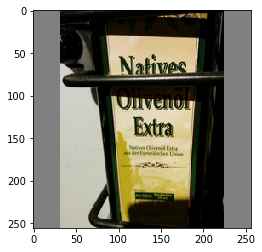

In [23]:
np.set_printoptions(threshold=1000, linewidth=10000)

def display(X, y, n):
    pic = X[n] # .reshape(28, 28)
    plt.imshow(pic)
    with pd.option_context("display.max_columns", 1000):
        print(n)
        print(y[n])
        print(pic)
    
n = np.random.randint(0, train_images.shape[0])
display(train_images, train_labels, 1234)

In [24]:
CLASS_COUNT = len(np.unique(train_labels))
assert len(np.unique(train_labels)) == CLASS_COUNT
CLASS_COUNT

25

In [25]:
np.unique(train_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

#### Normalize data

Data normalization helps the numerical algorithms to converge faster (or at all).
Our data is in range [0, 255]; we will normalize it to be in the range [0.1, 0.9].

In [26]:
def normalize(image_data, labels, min_x=None, max_x=None):
    min_x = np.min(image_data) if min_x is None else min_x
    max_x = np.max(image_data) if max_x is None else max_x
    delta = max_x - min_x
    a, b = 0.1, 0.9

    rdd_images = sc.parallelize(image_data)
    rdd_labels = sc.parallelize(labels)

    rdd_sample = rdd_images \
        .zip(rdd_labels) \
        .map(lambda features_labels: \
             Sample.from_ndarray((features_labels[0] - min_x) * (b - a) / delta, features_labels[1] + 1))
    return rdd_sample, min_x, max_x

#### Normalize data.
Use Min/Max normalization to improve convergence.

In [27]:
X_train_norm, min_x, max_x = normalize(train_images, train_labels)

**Important**: apply the same Min/Max values from the training set to the testing set:

In [28]:
X_test_norm, _, _ = normalize(test_images, test_labels, min_x, max_x)

In [29]:
# X_test_norm.shape

Inspect samples:

In [30]:
# samples = X_test_norm.collect()

In [31]:
# samples[0]

In [32]:
def LeNet(class_num):
    model = Sequential()
    model.add(Reshape([1, 28, 28]))
    
    model.add(SpatialConvolution(1, 6, 5, 5).set_name('conv1'))
    model.add(ReLU())
    
    model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool1'))
    
    model.add(SpatialConvolution(6, 16, 5, 5).set_name('conv2'))
    model.add(ReLU())
    
    model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool2'))
    
    model.add(Reshape([16 * 4 * 4]))
    
    model.add(Linear(16 * 4 * 4, 84).set_name('fc1'))
    model.add(ReLU())

#     model.add(Linear(120, 84).set_name('fc2'))
#     model.add(ReLU())

    model.add(Linear(84, class_num).set_name('score'))
    model.add(LogSoftMax())
    
    return model

In [33]:
lenet_model = LeNet(CLASS_COUNT)

creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


#### Hyperparameters

In [35]:
EPOCHS = 5

Create training loop:

In [36]:
optimizer = Optimizer(model=lenet_model, training_rdd=X_train_norm,
                      criterion=ClassNLLCriterion(),
                      optim_method=SGD(nesterov=True, momentum=0.9, dampening=0.0),
                      end_trigger=MaxEpoch(EPOCHS),
                      batch_size=64)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer


In [37]:
# Set the validation logic
optimizer.set_validation(batch_size=128, val_rdd=X_test_norm,
                         trigger=EveryEpoch(),
                         val_method=[Top1Accuracy()])

creating: createEveryEpoch
creating: createTop1Accuracy


In [38]:
import shutil
from os import path

LOG_DIR = '/tmp/bigdl_summaries'
APP_NAME='lenet5-' # + datetime.now().strftime("%Y%m%d-%H%M%S")
try:
    shutil.rmtree('/private' + LOG_DIR + '/' + APP_NAME)
except:
    pass

In [39]:
train_summary = TrainSummary(log_dir=LOG_DIR, app_name=APP_NAME)
train_summary.set_summary_trigger("Parameters", SeveralIteration(10)) 
val_summary = ValidationSummary(log_dir=LOG_DIR, app_name=APP_NAME)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ", APP_NAME)

creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  lenet5-


#### Start training

In [40]:
%%time
trained_model = optimizer.optimize()
print("Done")

Py4JJavaError: An error occurred while calling o124.optimize.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 5.0 failed 1 times, most recent failure: Lost task 0.0 in stage 5.0 (TID 4, localhost, executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.lang.reflect.Array.newInstance(Array.java:75)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1678)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1347)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2018)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:1942)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:1808)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1353)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:373)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:75)
	at org.apache.spark.serializer.DeserializationStream.readValue(Serializer.scala:158)
	at org.apache.spark.serializer.DeserializationStream$$anon$2.getNext(Serializer.scala:188)
	at org.apache.spark.serializer.DeserializationStream$$anon$2.getNext(Serializer.scala:185)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:438)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:32)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:438)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1336)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1336)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1336)
	at com.intel.analytics.bigdl.dataset.DataSet$$anonfun$6.apply(DataSet.scala:363)
	at com.intel.analytics.bigdl.dataset.DataSet$$anonfun$6.apply(DataSet.scala:362)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2119)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1026)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1008)
	at com.intel.analytics.bigdl.optim.DistriOptimizer$.optimize(DistriOptimizer.scala:146)
	at com.intel.analytics.bigdl.optim.DistriOptimizer.optimize(DistriOptimizer.scala:968)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.lang.reflect.Array.newInstance(Array.java:75)
	at java.io.ObjectInputStream.readArray(ObjectInputStream.java:1678)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1347)
	at java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2018)
	at java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:1942)
	at java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:1808)
	at java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1353)
	at java.io.ObjectInputStream.readObject(ObjectInputStream.java:373)
	at org.apache.spark.serializer.JavaDeserializationStream.readObject(JavaSerializer.scala:75)
	at org.apache.spark.serializer.DeserializationStream.readValue(Serializer.scala:158)
	at org.apache.spark.serializer.DeserializationStream$$anon$2.getNext(Serializer.scala:188)
	at org.apache.spark.serializer.DeserializationStream$$anon$2.getNext(Serializer.scala:185)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:438)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:32)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:438)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1336)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1336)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1336)
	at com.intel.analytics.bigdl.dataset.DataSet$$anonfun$6.apply(DataSet.scala:363)
	at com.intel.analytics.bigdl.dataset.DataSet$$anonfun$6.apply(DataSet.scala:362)


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 38734)
----------------------------------------


Traceback (most recent call last):
  File "/opt/conda/envs/py35/lib/python3.5/socketserver.py", line 313, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/envs/py35/lib/python3.5/socketserver.py", line 341, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/envs/py35/lib/python3.5/socketserver.py", line 354, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/envs/py35/lib/python3.5/socketserver.py", line 681, in __init__
    self.handle()
  File "/root/spark-2.2.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/root/spark-2.2.0-bin-hadoop2.7/python/pyspark/serializers.py", line 577, in read_int
    raise EOFError
EOFError


In [ ]:
import random
predictions = trained_model.predict(X_test_norm)

In [ ]:
preds = predictions.collect()

In [ ]:
pred_classes = [np.argmax(p) for p in preds]
pred_classes[:10]

In [ ]:
def display_letter_predict(pred_classes):
    N = test_images.shape[0]
    i = random.randint(0, N)
    image = test_images[i]
    pred = pred_classes[i]
    print('Prediction:', pred)
    display(test_images, test_labels, i)

display_letter_predict(pred_classes)

#### Problem:

Find several example from the test prediction where we incorrectly predicted the letter.